# Count star structures
... without considering node/edge attributes. Also ignore ducplicate edges and make graph undirected.


In [15]:
"""example code for counting subgraph structures"""
from subgraph_counting import pattern, conversion, datasets
from subgraph_counting.graph import Graph
from torch_geometric.loader import DataLoader
import torch

PLOT_ROOT = '../data/figures'
DATA_ZINC = '../data/datasets/ZINC'
device = 'cuda'


In [2]:
# get ZINC dataset
datasets_pyg = datasets.get_zinc_dataset(f'{DATA_ZINC}/original')
node_feature_size = 1
target_features_size = 1
batch_size = 100
criterion = torch.nn.L1Loss()

In [16]:
# get and prestransform ZINC dataset for star 1-8
from subgraph_counting.transform import AnnotateSubgraphIsomorphisms, AnnotateDegree, AnnotateOnes, Shorten
from torch_geometric.transforms.compose import Compose
subgraph_patterns = []
for i in range(2,9):
    subgraph_pattern = pattern.create_star(i)
    subgraph_patterns.append(conversion.igraph_to_pyg_graph(subgraph_pattern))

pre_transform = AnnotateSubgraphIsomorphisms(subgraph_patterns, True)
transform = Compose([AnnotateOnes('x'), Shorten('y', 0, 2, 3)])
#transform = Compose([AnnotateDegree('x', replace=True, norm=1/4), Shorten('y', 0, 2, 3)])
datasets_pyg = datasets.get_zinc_dataset(f'{DATA_ZINC}/star1-8', 
    pre_transform=pre_transform,
    transform=transform
    )
node_feature_size = 1
target_features_size = 1    # shortened to 1 (3-star)
                            # there is no node with more than 5 neighbors in the dataset
batch_size = 100
criterion = torch.nn.L1Loss()

In [ ]:
# get and prestransform ZINC dataset for cycle 6
from subgraph_counting.transform import AnnotateSubgraphIsomorphisms
subgraph_pattern = pattern.create_cycle(6)
subgraph_pattern_pyg = conversion.igraph_to_pyg_graph(subgraph_pattern)

transform = AnnotateSubgraphIsomorphisms([subgraph_pattern_pyg], True)
datasets_pyg = datasets.get_zinc_dataset(DATA_ZINC, pre_transform=transform)
node_feature_size = 1
target_features_size = 1
batch_size = 100
criterion = torch.nn.L1Loss()

#### Show subgraph patterns

In [17]:
train_loader = DataLoader(datasets_pyg['train'], batch_size, shuffle=True)
test_loader = DataLoader(datasets_pyg['test'], batch_size)

#### Show target statistics

In [18]:
# statistics
targets = [data.y for data in datasets_pyg['train']]
features = [torch.max(data.x, dim=0).values for data in datasets_pyg['train']]

print(f'Graphs: {len(targets)}')
print(f'Avg Target: {torch.mean(torch.stack(targets))}')
print(f'Max Feature: {torch.max(torch.stack(features), dim=0).values}')


Graphs: 10000
Avg Target: 8.256799697875977
Max Feature: tensor([1])


# Train

#### Subgraph Counting Baseline MAX

In [9]:

def max(loader):
    values = []
    for data in loader:
        values.append(data.y.reshape(batch_size, target_features_size).float())
    values = torch.stack(values)
    max_vals = torch.max(values, dim=0).values
    max_vals = torch.max(max_vals, dim=0).values
    return max_vals

def test(loader, reference):
    reference = reference.repeat(batch_size ,1)
    losses = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        y = data.y.reshape(batch_size, target_features_size).float()
        loss = criterion(y, reference)
        losses.append(loss)
    return torch.mean(torch.as_tensor(losses)).item()

max_train = max(train_loader)
max_test = max(test_loader)
max_vals = torch.max(max_train, max_test)
train_acc = test(train_loader, max_vals)
test_acc = test(test_loader, max_vals)
print(f'Baseline_MAX Train MAE: {train_acc:.4f}, Test MAE: {test_acc:.4f}')

Baseline_MAX Train MAE: 20.7432, Test MAE: 20.6640


In [19]:

def mean(loader):
    values = []
    for data in loader:
        values.append(data.y.reshape(batch_size, target_features_size).float())
    values = torch.stack(values)
    max_vals = torch.mean(values, dim=0)
    max_vals = torch.mean(max_vals, dim=0)
    return max_vals

def test(loader, reference):
    reference = reference.repeat(batch_size ,1)
    losses = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        y = data.y.reshape(batch_size, target_features_size).float()
        loss = criterion(y, reference)
        losses.append(loss)
    return torch.mean(torch.as_tensor(losses)).item()

mean_train = mean(train_loader)
mean_test = mean(test_loader)
mean_vals = mean_train
train_acc = test(train_loader, mean_vals)
test_acc = test(test_loader, mean_vals)
print(f'Baseline_MEAN Train MAE: {train_acc:.4f}, Test MAE: {test_acc:.4f}')

Baseline_MEAN Train MAE: 2.0375, Test MAE: 2.0618


#### Models
- GraphConv
- GraphConv 1 layer + mlp´
- GCNConv (for reference, does not work due to average pooling of input features)


In [20]:
from torch_geometric.nn import GraphConv, Linear, global_add_pool, BatchNorm
from torch.nn import ModuleList, Sequential
import torch.nn as nn
import torch.nn.functional as F
from ogb.graphproppred.mol_encoder import AtomEncoder

class GraphConvNetDeep(torch.nn.Module):
    def __init__(self, graphConvLayers, activation, readoutLayer,
                 node_emb = None,
                 prePoolMlp = None, postPoolMlp = None, 
                 batchNorm = 0, dropOut = 0,
                 differenceResidualConnections = True):
        super().__init__()
        torch.manual_seed(12345)
        self.node_emb = node_emb
        self.conv = graphConvLayers
        self.activation = activation
        if batchNorm > 0:
            self.batchNorm = ModuleList([BatchNorm(batchNorm) for _ in range(len(graphConvLayers))])
        else:
            self.batchNorm = None
        self.prePoolMlp = prePoolMlp
        self.postPoolMlp = postPoolMlp
        self.dropOut = dropOut
        self.readoutLayer = readoutLayer
        self.differenceResidualConnections = differenceResidualConnections

    def forward(self, x, edge_index, batch):
        # one convolution
        # one mpl (e.g. linear relu linear relu linear ...)
        # idea: annotate stars with 1 to 8 (8 dimensions), low loss -> network works
        # todo: cycles -> of size x.
        # Report: 
        # GCN -> does not work with ones (avg.)
        

        # 1. Obtain node embeddings
        if self.node_emb is not None:
            x = self.node_emb(x.int())
        drc = []
        if self.batchNorm is not None:
            for layer, batch_norm in zip(self.conv, self.batchNorm):
                h = self.activation(batch_norm(layer(x, edge_index)))
                if self.differenceResidualConnections:
                    drc.append(h)
                    x = x + h
                else:
                    x = h
        else:
            for layer in self.conv:
                h = self.activation(layer(x, edge_index))
                if self.differenceResidualConnections:
                    drc.append(h)
                    x = x + h
                else:
                    x = h
        if len(drc) > 0:
            x = torch.cat([x, *drc], dim=-1)
        if self.prePoolMlp is not None:
            x = self.prePoolMlp(x)

        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]

        if self.postPoolMlp is not None:
            x = self.postPoolMlp(x)

        if self.dropOut > 0:
            x = F.dropout(x, p=self.dropOut, training=self.training)
        # 4. Apply a final linear layer
        x = self.readoutLayer(x)
        
        return x



In [ ]:
# original ZINC task
hidden_size = 5
differenceResidualConnections=False

node_embedding = AtomEncoder(20)
channelsGraphConv = [20, hidden_size, hidden_size, hidden_size, hidden_size]
gcLayers = ModuleList([GraphConv(c1, c2) for c1, c2 in zip(channelsGraphConv[:-1], channelsGraphConv[1:])])

channelsLinear = []
mlp_hirachy = [[Linear(c1, c2), nn.ReLU()] for c1, c2 in zip(channelsLinear[:-1], channelsLinear[1:])]
mlp_flat_pre = Sequential(*[item for sublist in mlp_hirachy for item in sublist])
if differenceResidualConnections:
    channelsLinear = [hidden_size * (len(channelsGraphConv)), hidden_size]
else:
    channelsLinear = []
mlp_hirachy = [[Linear(c1, c2), nn.ReLU()] for c1, c2 in zip(channelsLinear[:-1], channelsLinear[1:])]
mlp_flat_post = Sequential(*[item for sublist in mlp_hirachy for item in sublist])

readoutLayer = Linear(hidden_size, target_features_size)
activation = nn.ReLU()
model = GraphConvNetDeep(gcLayers,
                         activation,
                         readoutLayer,
                         node_embedding,
                         prePoolMlp=mlp_flat_pre,
                         postPoolMlp=mlp_flat_post,
                         batchNorm=hidden_size,
                         dropOut=.1,
                         differenceResidualConnections=False).to(device)

In [30]:
hidden_size = 5
differenceResidualConnections=False
batchNorm = hidden_size if batch_size > 1 else 0
dropOut=0
#node_embedding = AtomEncoder(hidden_size)
node_embedding = None
#channelsGraphConv = [node_feature_size, hidden_size, hidden_size, hidden_size, hidden_size]
channelsGraphConv = [node_feature_size, hidden_size]
gcLayers = ModuleList([GraphConv(c1, c2) for c1, c2 in zip(channelsGraphConv[:-1], channelsGraphConv[1:])])

#channelsLinear = [hidden_size, hidden_size, target_features_size]
channelsLinear = [] # careful!!!! do not use this if batchsize > 1. otherwise features of different graphs will be connected
mlp_hirachy = [[Linear(c1, c2), nn.LeakyReLU(), BatchNorm(c2)] for c1, c2 in zip(channelsLinear[:-1], channelsLinear[1:])]
mlp_flat_pre = Sequential(*[item for sublist in mlp_hirachy for item in sublist])
if differenceResidualConnections:
    channelsLinear = [hidden_size * (len(channelsGraphConv)), hidden_size]
else:
    channelsLinear = [hidden_size,hidden_size,hidden_size]
mlp_hirachy = [[Linear(c1, c2), nn.LeakyReLU(), BatchNorm(c2)] for c1, c2 in zip(channelsLinear[:-1], channelsLinear[1:])]
mlp_flat_post = Sequential(*[item for sublist in mlp_hirachy for item in sublist])

readoutLayer = Linear(hidden_size, target_features_size)
activation = nn.LeakyReLU()
model = GraphConvNetDeep(gcLayers,
                         activation,
                         readoutLayer,
                         node_embedding,
                         prePoolMlp=mlp_flat_pre,
                         postPoolMlp=mlp_flat_post,
                         batchNorm=batchNorm,
                         dropOut=dropOut,
                         differenceResidualConnections=False).to(device)

GraphConvNetDeep(
  (conv): ModuleList(
    (0): GraphConv(1, 5)
  )
  (activation): LeakyReLU(negative_slope=0.01)
  (batchNorm): ModuleList(
    (0): BatchNorm(5)
  )
  (prePoolMlp): Sequential()
  (postPoolMlp): Sequential(
    (0): Linear(5, 5, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm(5)
    (3): Linear(5, 5, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm(5)
  )
  (readoutLayer): Linear(5, 1, bias=True)
)
Total trainable parameters: 111
Epoch: 001, Train MAE: 8.1203, Test MAE: 8.2042
Epoch: 002, Train MAE: 7.6997, Test MAE: 7.7668
Epoch: 003, Train MAE: 7.7139, Test MAE: 7.7891
Epoch: 004, Train MAE: 7.0821, Test MAE: 7.1688
Epoch: 005, Train MAE: 6.6973, Test MAE: 6.7778
Epoch: 006, Train MAE: 6.1334, Test MAE: 6.2139
Epoch: 007, Train MAE: 5.5289, Test MAE: 5.5899
Epoch: 008, Train MAE: 4.0947, Test MAE: 4.1701
Epoch: 009, Train MAE: 3.7584, Test MAE: 3.8110
Epoch: 010, Train MAE: 2.7983, Test MAE: 2.8479
Epoch: 011, Train MAE: 

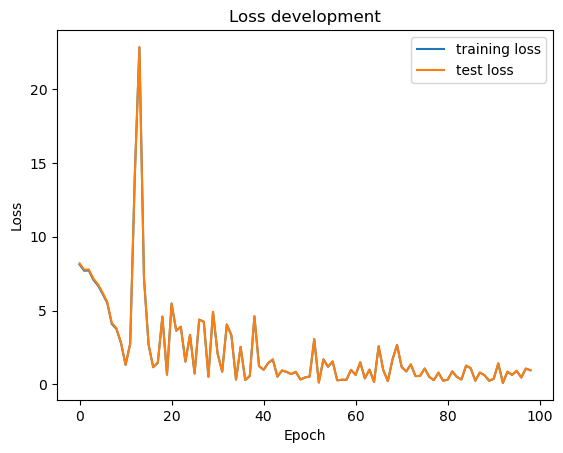

In [31]:
lr=0.0006
epochs=100
train_loader = DataLoader(datasets_pyg['train'], batch_size)
test_loader = DataLoader(datasets_pyg['test'], batch_size)
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{model}\nTotal trainable parameters: {trainable_parameters}')

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #.003

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x.float().to(device), data.edge_index.to(device), data.batch.to(device))  # Perform a single forward pass.
         loss = criterion(out, data.y.reshape(batch_size, target_features_size).float().to(device))  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

@torch.no_grad()
def test(loader):
    model.eval()
    losses = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x.float().to(device), data.edge_index.to(device), data.batch.to(device))  
        loss = criterion(out, data.y.reshape(batch_size, target_features_size).float().to(device))
        losses.append(loss)
    return torch.mean(torch.as_tensor(losses)).item()

train_losses = []
test_losses = []

for epoch in range(1, epochs):
    train()
    train_acc = test(train_loader)
    train_losses.append(train_acc)
    test_acc = test(test_loader)
    test_losses.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train MAE: {train_acc:.4f}, Test MAE: {test_acc:.4f}')

import matplotlib.pyplot as plt
plt.plot(train_losses, label="training loss")
plt.plot(test_losses, label="test loss")
plt.title("Loss development")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

# Explain

from torch_geometric.data import Data
from torch_geometric.explain import Explainer, PGExplainer

dataset = datasets_annotated_pyg['val']
loader = DataLoader(dataset, batch_size=1, shuffle=True)

explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    # Include only the top 10 most important edges:
    threshold_config=dict(threshold_type='topk', value=10),
)

# PGExplainer needs to be trained separately since it is a parametric
# explainer i.e it uses a neural network to generate explanations:
for epoch in range(30):
    for batch in loader:
        loss = explainer.algorithm.train(
            epoch, model, batch.x, batch.edge_index, target=batch.target)

# Generate the explanation for a particular graph:
explanation = explainer(dataset[0].x, dataset[0].edge_index)
print(explanation.edge_mask)